# LANGTON'S ANT: A BRIEF OVERVIEW

### Presented by Watty

***


Langton's ant is a simple 2-dimensional cellular automata (henceforth referred to as CA) invented by Chris Langton in 1986 that yields surprisingly complex emergent behaviour. A 2D plane is divided into square cells, and each cell is filled with one of two colors - A or B. This is the start state for the CA. We'll make a variety of these for experimenting with. An arbitrary cell on the plane is then identified as our starting cell, and it will contain our ant at the start. We'll be defaulting to the middle of the grid for our experiments, though this can be changed easily. The CA was proven in 2000 to be Turing complete, and follows the following instructions:

In every step of the CA, the ant will make a move as follows:
- if the ant is on a cell colored A, the ant will turn 90 degrees clockwise, flip the color of the cell it is on, then move forward into the next cell.
- if the ant is on a cell colored B, the ant will turn 90 degrees counter-clockwise, flip the color of the cell it is on, then move forward into the next cell.

We can animate the behaviour of this cellular automaton relatively easily with Python - before examining any animations, though, let's take a look at some various endstates of Langton's Ant on a grid of a given size, after a given number of steps. 

Let's start off by importing the packages we'll need to make this work. 



In [48]:
import timeit
from pprint import pprint

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

%matplotlib inline 
# this is a magic command for jupyter notebooks for inline plotting
matplotlib.rc('animation', html='jshtml')

Now that we have the tools at hand to start working, let's start by creating a Ant2D class for our ant object. Let's use black and white for our cells, as the colors are easy to discern and distinguish from one another. Our Ant will be denoted in red. Let's start by configuring our color selections for the array we'll use for the plane. These colors and settings can be change by changing the values stored in the `PLT_OPTIONS` dictionary. 


In [2]:
PLT_OPTIONS = dict( 
    # This dictionary contains the default options for the imshow function.
    # Changing these options will change the default options for all plots.
    cmap='Blues', # color map
    interpolation='none', # interpolation method
    origin='upper', # origin of the grid
)

We now need a function for visualization of an Ant2D object. Let's use the `plot_2D_array` function [originally introduced from Lab 6](https://github.com/wattyven/cap-comp215/blob/main/labs/lab06.ipynb), but with some minor tweaks. For starters, we'll need to add the ability to track the current location of the ant and visually mark where it is at any given step. We'll use the name `ant_loc`, short for ant location, to denote this, and this parameter will be provided to the function in the form of a tuple pair of X-Y coordinates. This will be fed to the function via another function from within our Ant2D class, so we won't need to change anything here. 

In [46]:
def plot_2D_array(array, ant_loc, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    # draw the cell at antloc as a red square
    axes.plot(ant_loc[0] - 1, ant_loc[1] - 1, 'rs')
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**PLT_OPTIONS, **options}
    axes.imshow(array, **options)

Next, let's declare a couple of variables. While the Ant2D class will be configured to accept different height and width values should you desire, by default, let's make our plots square for simple visualization.

Both the X and the Y dimension of these square plots will be $n$ units for now. This can be changed if desired. Let's start off with an easy-to-work with grid size of 100 x 100.

In [4]:
# side length of the grid we'll be working on
n = 100 

Let's also come up with a couple easy to use start states. Let's make a couple functions for dynamically creating start states: one for a checkboard start state, one for a completely randomized start state, and one with a completely white grid. 

In [5]:
def checkerboard_state(dimx, dimy):
    '''returns a checkerboard grid of size dimx by dimy'''
    return np.array([[((i + j) % 2) for i in range(dimx)] for j in range(dimy)])

def random_state(dimx, dimy):
    '''returns a random grid of size dimx by dimy'''
    return np.array([[np.random.randint(0, 2) for i in range(dimx)] for j in range(dimy)])

def blank_state(dimx, dimy):
    '''returns a blank grid of size dimx by dimy'''
    return np.array([[0 for i in range(dimx)] for j in range(dimy)])

For now, let's start off with a 100 x 100 checkerboard pattern as our initial start state. We'll also implement our Ant2D class such that this will be our default start state if no argument is given for the starting parameter. Let's display this grid just to get an idea of what we're going to be working with. 

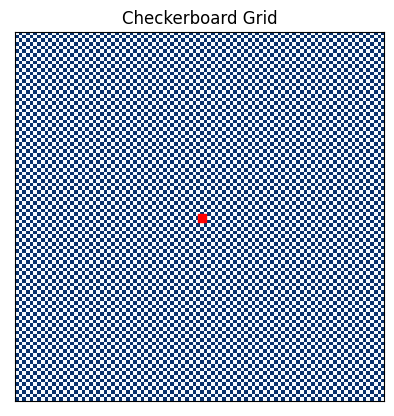

In [6]:
checkerboard_100 = checkerboard_state(n, n)
# display the checkerboard grid
plot_2D_array(checkerboard_100, (50, 50), title='Checkerboard Grid')


As this cellular automata continually modifies the plane it resides in at a rate of only one cell per step, we won't need a correlation matrix to compute the next step of the CA. We'll use an array to represent the grid, a pair of X-Y coordinates to keep track of the ant, and we'll apply a simple single-line ruleset to keep track of the bit to be flipped as well as the direction for the ant to turn in. 

Within our class we'll need several functions:

- `__init__` to initialize our class `Ant2D`,
- `turn` to determine the direction our ant will move in next, after checking the color of the cell it's currently on,
- `step` to change colors, move our ant, and advance to the next step of the CA,
- `simulate` to advance our CA by a given number of steps,
- and `draw` to enable our CA to be easily visualized. 

Details for each function will be provided in its docstring and comments.

In [44]:
class Ant2D:
    '''class for a 2D Langton's Ant'''

    def __init__(self, width=n, height=n, grid=checkerboard_100, x=(n//2), y=(n//2), direction="up"):
        '''initializes the Ant2D object with some parameters:
        width and height are the dimensions of the grid
        grid is the grid the ant will be starting on
        x and y are the starting coordinates of the ant
        and direction is the starting direction of the ant'''
        self.width = width
        self.height = height
        self.grid = grid
        self.x = x # x coordinate of the ant
        self.y = y # y coordinate of the ant
        self.direction = direction
        self.rules = {"0": ("1", "right"), "1": ("0", "left")} # rules for Langton's Ant

    def turn(self, direction):
        '''turns the ant left or right and updates the direction attribute
        opted for a more verbose version of this function for readability'''
        if direction == "left": 
            if self.direction == "up":
                self.direction = "left"
            elif self.direction == "down":
                self.direction = "right"
            elif self.direction == "left":
                self.direction = "down"
            elif self.direction == "right":
                self.direction = "up"
        elif direction == "right":
            if self.direction == "up":
                self.direction = "right"
            elif self.direction == "down":
                self.direction = "left"
            elif self.direction == "left":
                self.direction = "up"
            elif self.direction == "right":
                self.direction = "down"

    def step(self):
        '''advances the CA by one step'''
        # get the current color of the cell the ant is on
        color = self.grid[self.y][self.x]
        # get the new color and turn direction from the rules
        new_color, turn_direction = self.rules[str(color)]
        # update the grid
        self.grid[self.y][self.x] = int(new_color)
        # turn the ant
        self.turn(turn_direction) 
        if self.direction == "up":
            self.y -= 1
        elif self.direction == "down":
            self.y += 1
        elif self.direction == "left":
            self.x -= 1
        elif self.direction == "right":
            self.x += 1
        # these next few lines are for wrapping around the edges
        if self.x < 0:
            self.x = self.width - 1
        elif self.x >= self.width:
            self.x = 0
        if self.y < 0:
            self.y = self.height - 1
        elif self.y >= self.height:
            self.y = 0

    def simulate(self, num_steps):
        '''simulates the automaton for num_steps steps'''
        for i in range(num_steps):
            self.step()

    def draw(self, axes=None, title='', step=''):
        '''draws the current state of the automaton whenever called'''
        plot_2D_array(self.grid, ant_loc=(self.x, self.y), axes=axes, title=title)

Let's try this out by visualizing the final state of Langton's Ant if it started out on our `checkerboard_100` grid every 400 steps until 2,000 steps, every 2,000 steps until 8,000 steps, then every 20,000 steps until 88,000 steps. To make this go more easily, let's create a list of these step counts, make a list of Ant objects to go along with it, and make another function for plotting multiple subplots (specifically, 12 plots, as that's how many step intervals we have in our list) on one big plot. 

We'll also use `timeit` from the Python library to quickly measure how long it takes to generate each of these plots, for future algorithm analysis verification. 

In [51]:
step_counts = [400, 800, 1200, 1600, 2000, 4000, 6000, 8000, 28000, 48000, 68000, 88000] # list of numbers of steps to simulate for
# we'll use this list of step counts to perform several experiments with different starting states. 

# create a list of 12 Ant2D objects based on the same starting state
checkerboard_ants = [Ant2D(grid=checkerboard_state(100, 100), x=(n//2), y=(n//2), direction="up") for i in range(12)]

def plot_12_ants(lst_ants):
    '''plots the 12 stages of the ant's simulation'''
    # use matplotlib to draw a plot with 12 subplots in 3 rows of 4
    fig, axes = plt.subplots(3, 4, figsize=(30, 20))
    # draw each ant in a different subplot
    for i in range(12):
        lst_ants[i].simulate(step_counts[i])
        lst_ants[i].draw(axes[i//4][i%4], step=step_counts[i])
        # label each subplot with the number of steps it was simulated for, as well as its runtime
        axes[i//4][i%4].set_title("Steps: " + str(step_counts[i]) + ", Runtime: " + str(round(timeit.timeit(lambda: lst_ants[i].simulate(step_counts[i]), number=1) * 1000, 2)) + " ms")

Now let's use our new function!

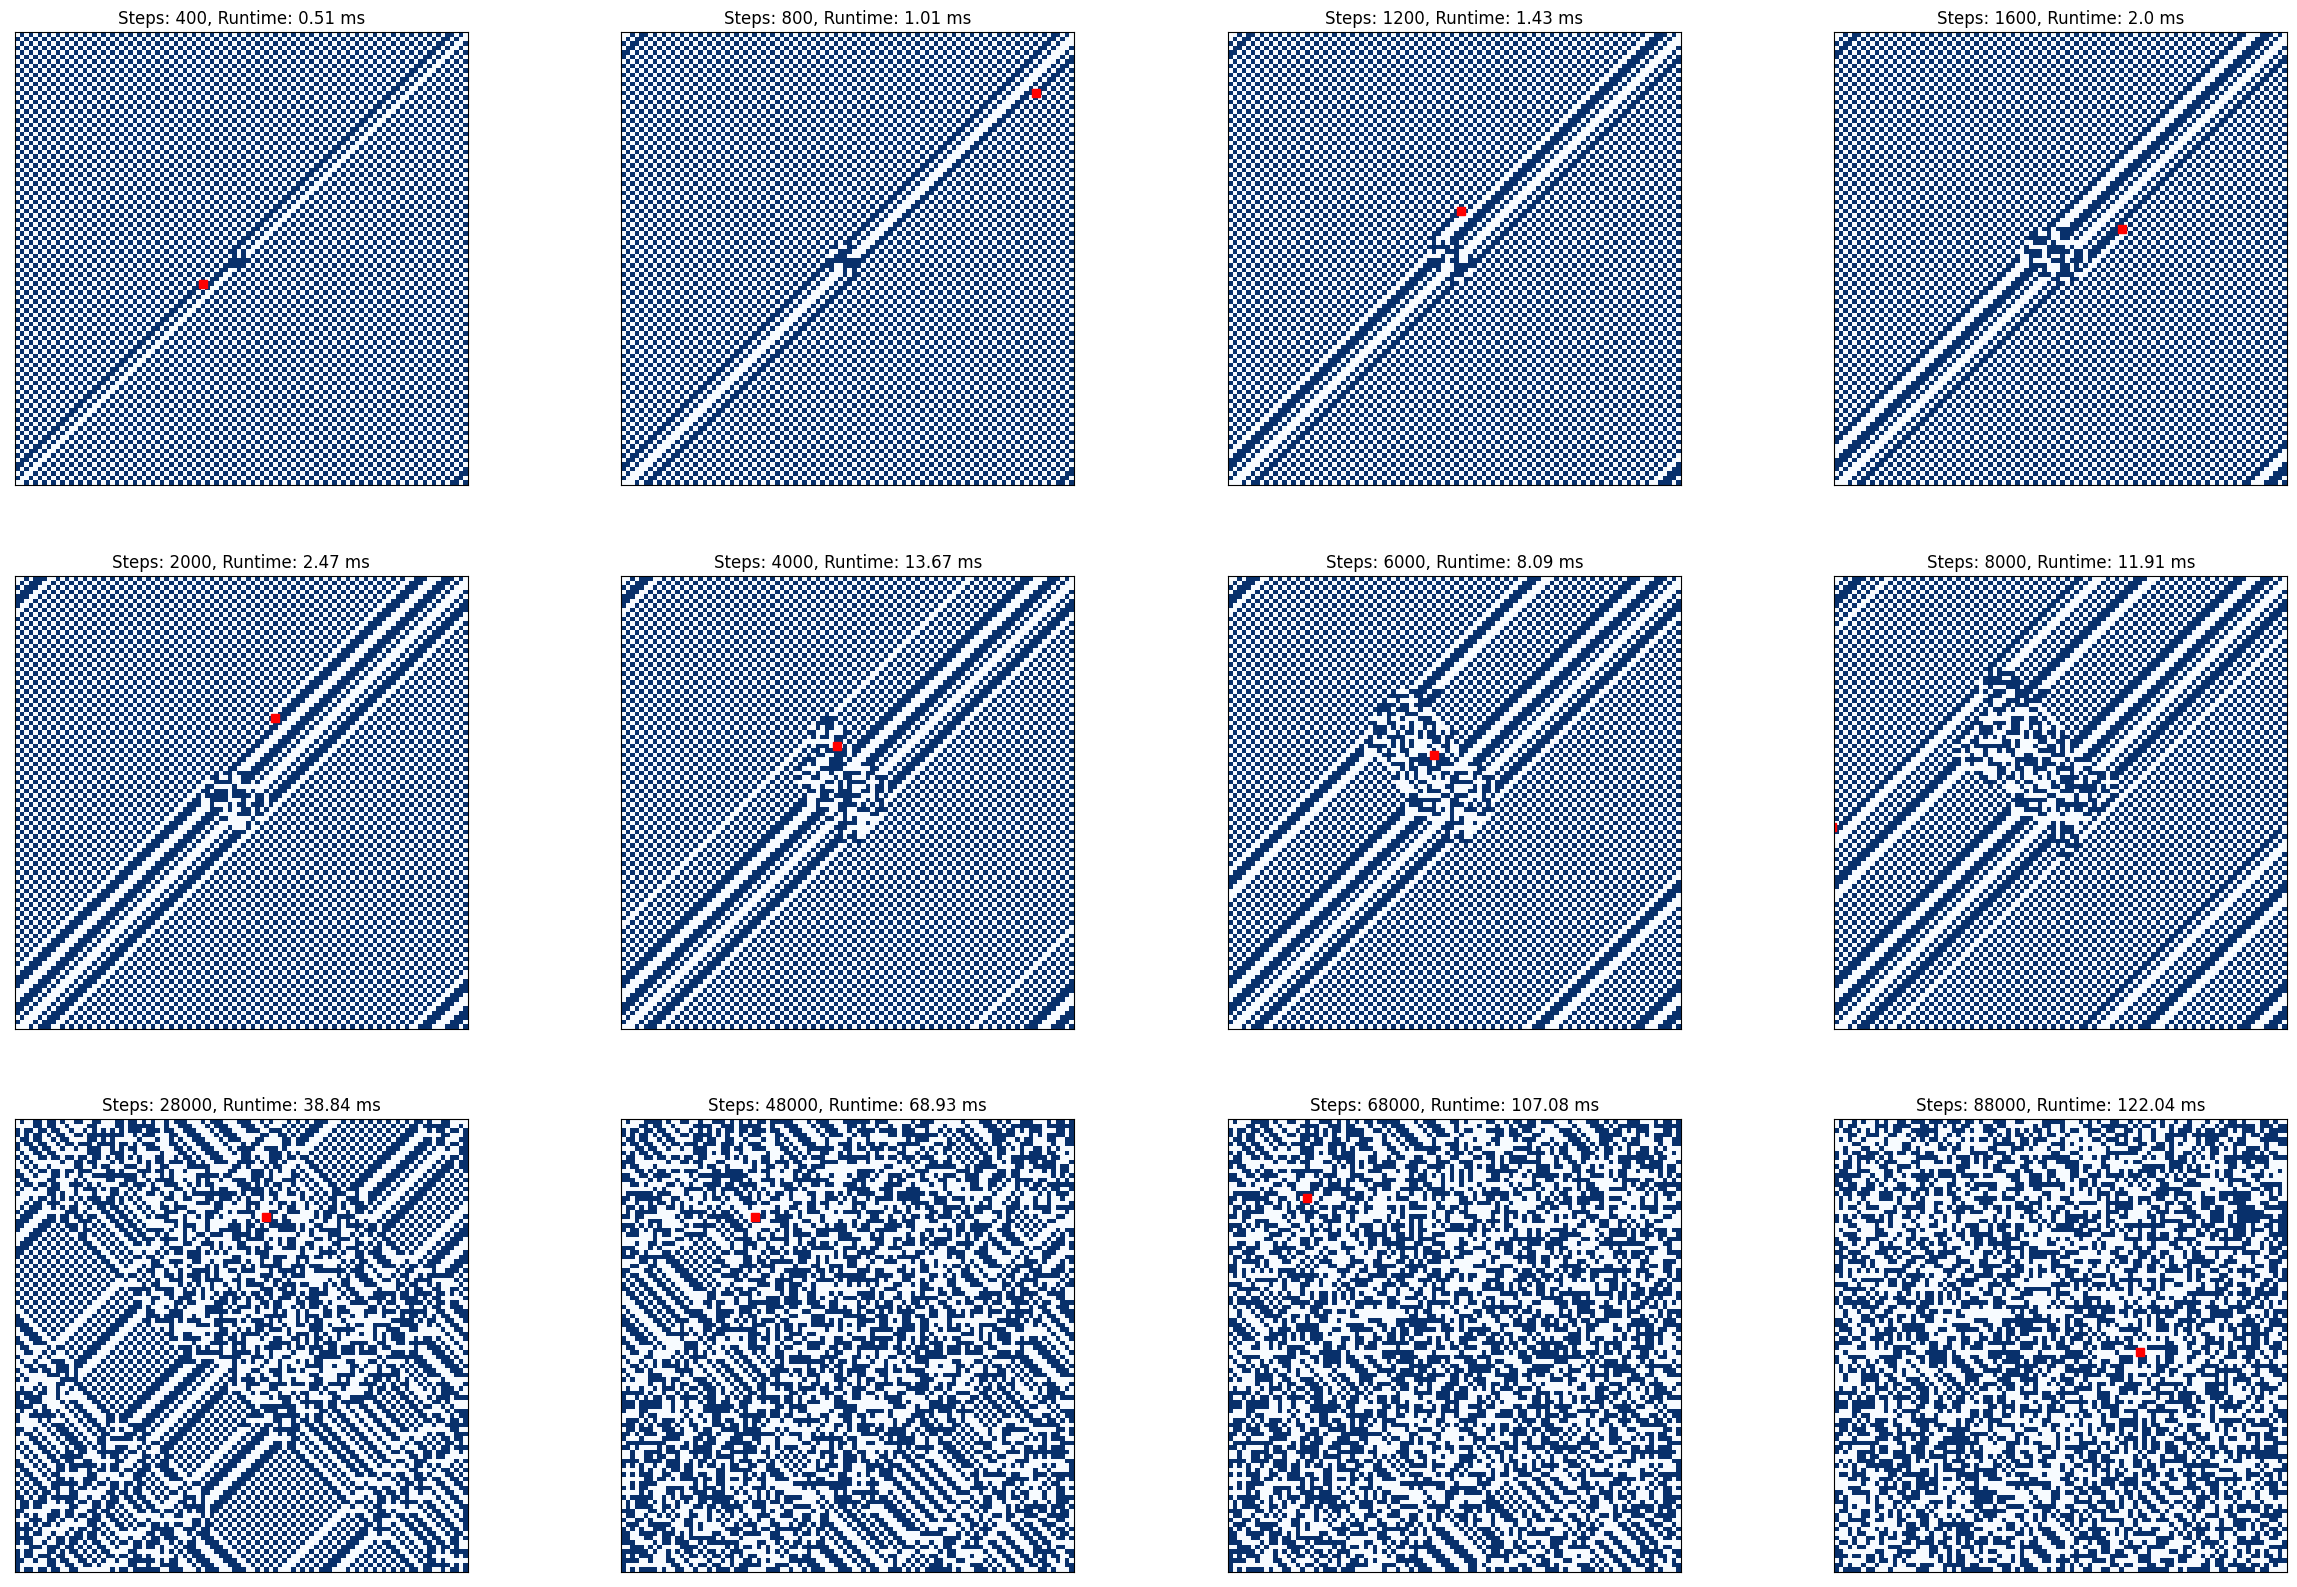

In [52]:
plot_12_ants(checkerboard_ants)

Now let's do this again, but instead of only using the checkerboard start state, let's also try out `blank_state` and `random_state`. Do note that for `random_state`, our function will be generating a new random starting pattern for each of the 12 plots. We *could* preserve the starting state, but as it currently stands, the code implemented thus far would merely be reassigning an alias to the start state so direct adaptation of the code would result in the plot moving forward a different number of steps than the rest. 

In [29]:
blank_ants = [Ant2D(grid=blank_state(100, 100), x=(n//2), y=(n//2), direction="up") for i in range(12)]

random_ants = [Ant2D(grid=random_state(100, 100), x=(n//2), y=(n//2), direction="up") for i in range(12)]

Time to plot the blank ants!

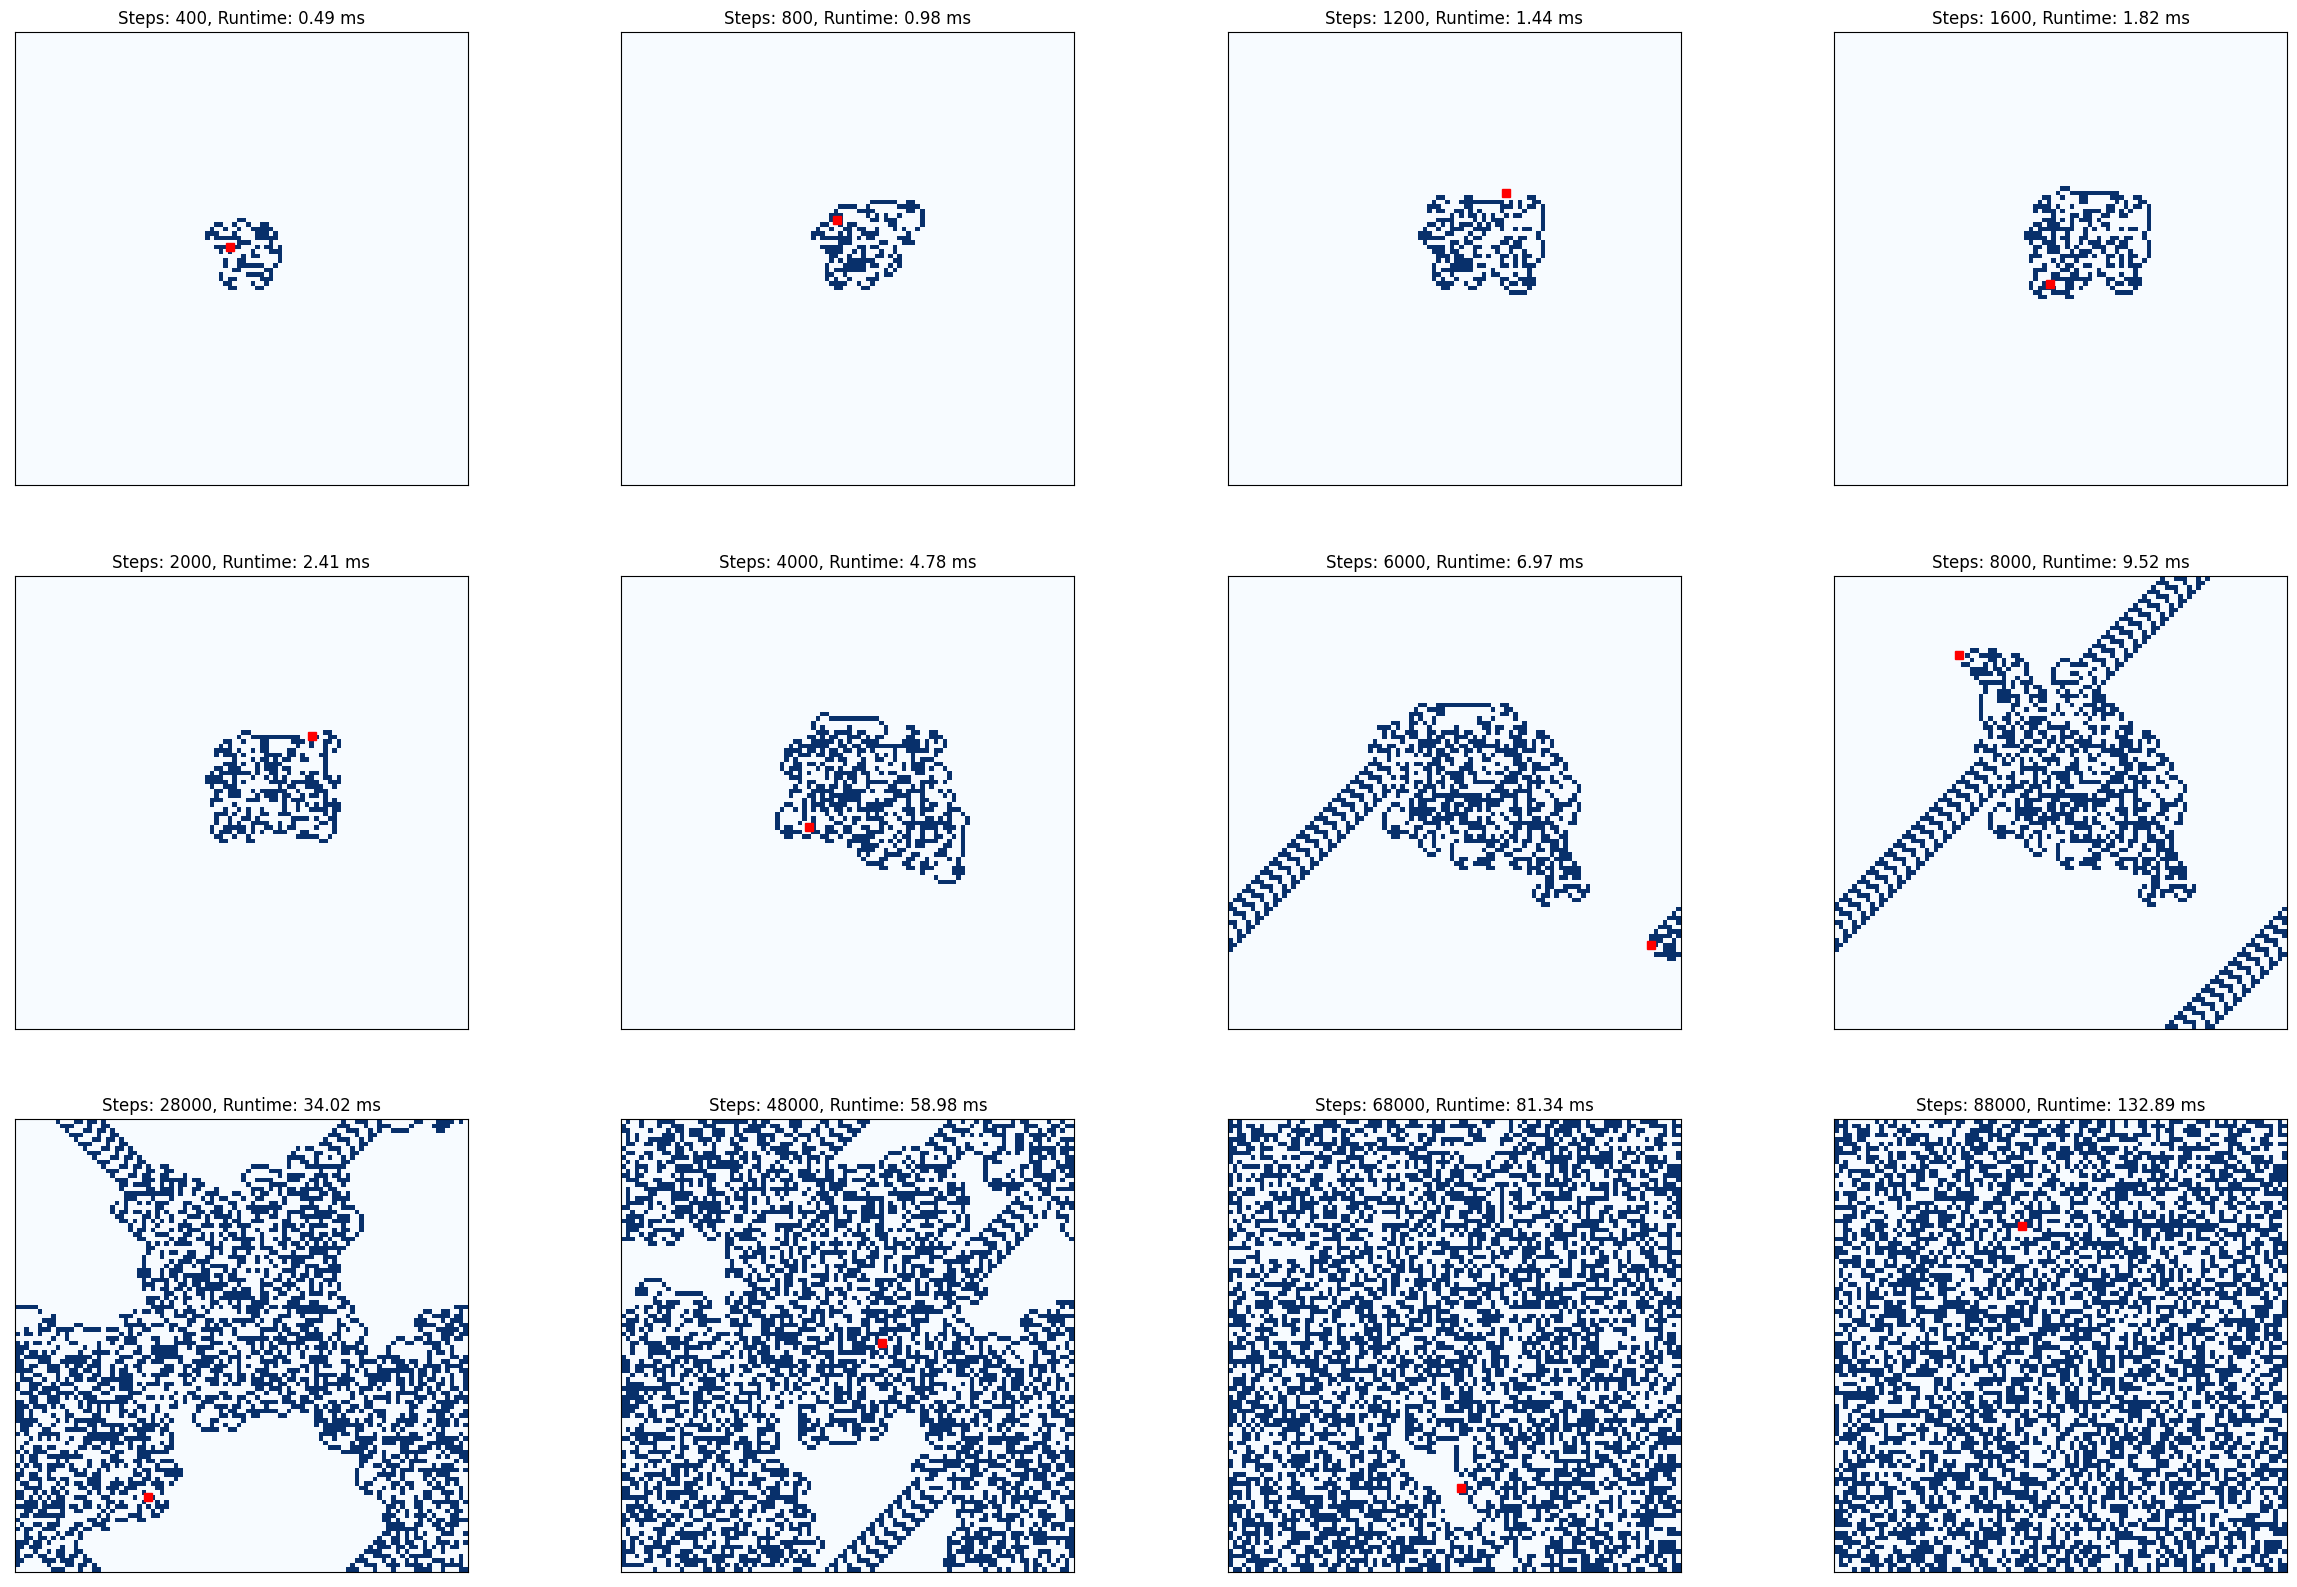

In [53]:
plot_12_ants(blank_ants)

And the random ants!

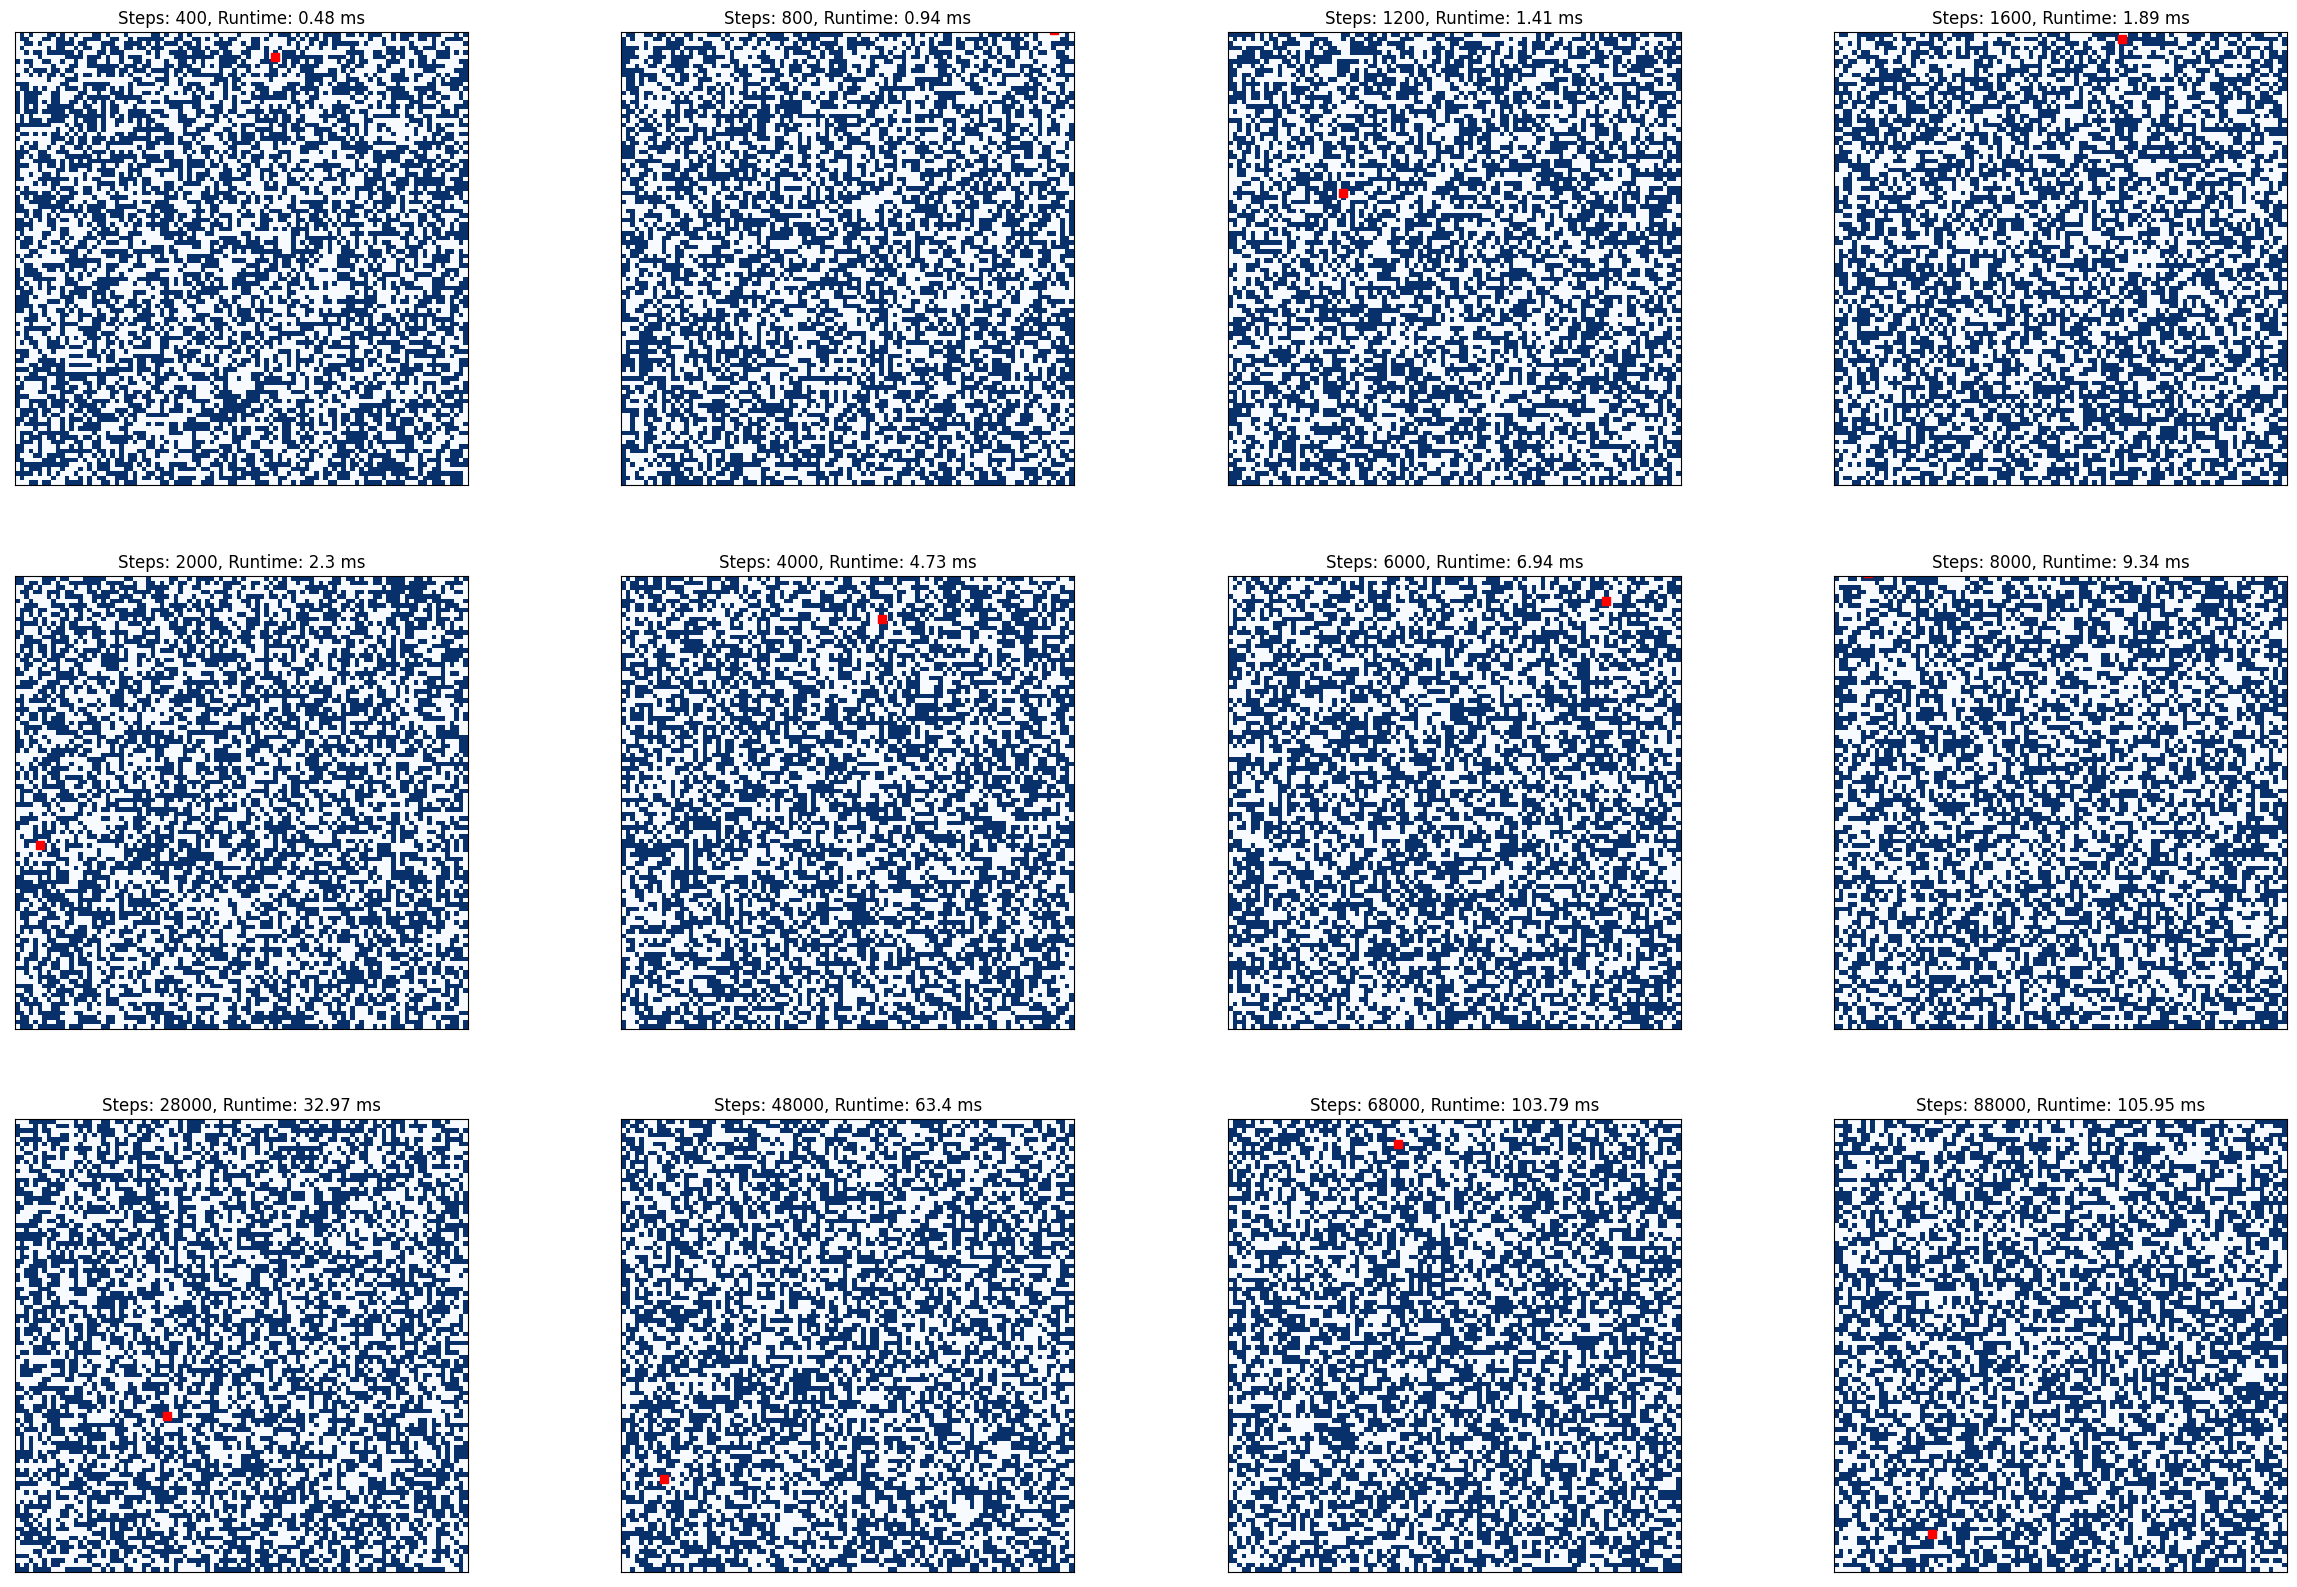

In [54]:
plot_12_ants(random_ants)

Finally, we can borrow the [Animation2D code from labs 7-10](https://github.com/wattyven/cap-comp215/blob/main/labs/lab10.ipynb) to visualize how the grid changes with each step of our CA. This code block has been copied directly from the referenced source material, and only a single line has been added to the `animate` function in order to label the step/frame number above the plot. 

In [42]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=150, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                # add title showing frame / step number to the plot
                self.ax.set_title("Frame / Step: " + str(i * self.steps_per_frame))
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

Finally, let's animate Langton's Ant on a fresh 40 x 40 checkerboard grid over the course of 1,000 steps to get an idea of how this thing advances step by step. We'll be using a smaller 40 x 40 grid as it'll be easier to see the changes over time on a smaller grid as opposed to a larger grid. 

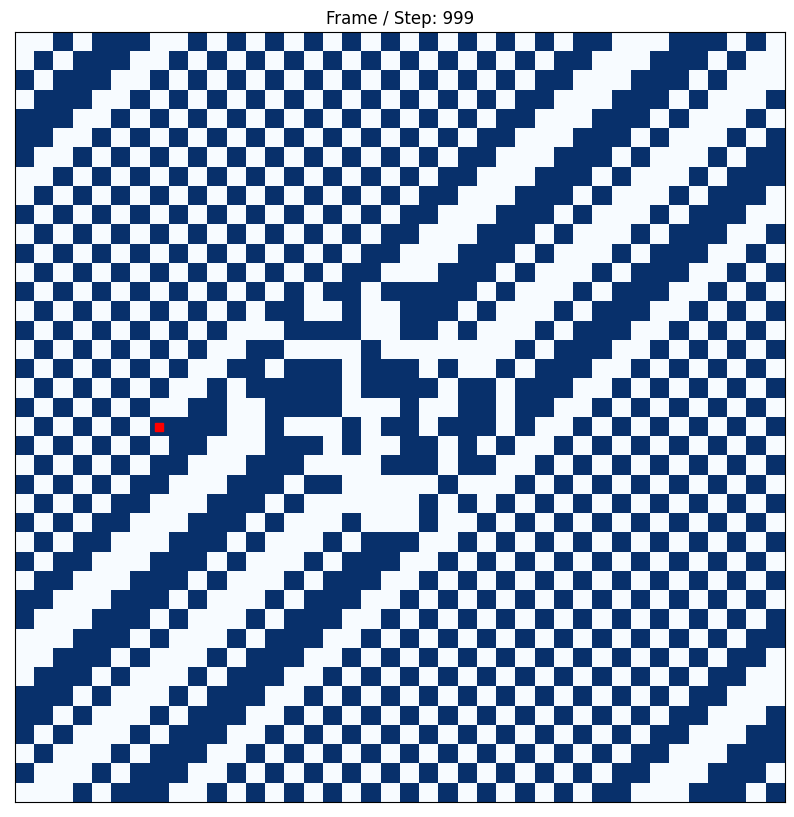

In [55]:
# let's input our grid size and number of steps
side_length = 40
num_steps = 1000

# create a new checkerboard state
anim_start_state = checkerboard_state(side_length, side_length)

# create a new ant object
anim_ant = Ant2D(width=side_length, height=side_length, grid=anim_start_state, x=(side_length//2), y=(side_length//2), direction="up")

# create a new animation object
anim = Animation2D(anim_ant, frames=num_steps, steps_per_frame=1, figsize=(10, 10))

# animate the ant!
anim.animate(interval=0.01)

From these experimental data, it seems that while Langton's Ant initially generates some rather ordinary results from its walk, after several hundred or thousand steps (at least on a smaller grid such as ours), its behaviour starts become less uniform. 